In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/CS613 Project/OASIS_alzheimer.zip' &> /dev/null

In [ ]:
from PIL import Image as I
from PIL import ImageFilter
import pandas as pd
import numpy as np
import cv2
import os
import shutil
import random
from distutils.file_util import copy_file
from statistics import mode
from sklearn.model_selection import train_test_split as split
from sklearn.metrics import confusion_matrix as cm
np.set_printoptions(suppress=True)

In [ ]:
non = '/content/Data/Non Demented'
vmild = '/content/Data/Very mild Dementia'
mild = '/content/Data/Mild Dementia'
mod = '/content/Data/Moderate Dementia'

In [ ]:
listmod = []
listnon = []
listvmild = []
listmild = []

for root, directories, files in os.walk(mod):
    for name in files:
        listmod.append(os.path.join(root, name))
for root, directories, files in os.walk(non):
    for name in files:
        listnon.append(os.path.join(root, name))
for root, directories, files in os.walk(vmild):
    for name in files:
        listvmild.append(os.path.join(root, name))
for root, directories, files in os.walk(mild):
    for name in files:
        listmild.append(os.path.join(root, name))

# Shuffle lists for random train / test
seed_value = 0
random.seed(seed_value)
random.shuffle(listmod)
random.shuffle(listnon)
random.shuffle(listvmild)
random.shuffle(listmild)

!mkdir ./Newdata
!mkdir ./Newdata/mildtrain
!mkdir ./Newdata/nontrain
!mkdir ./Newdata/vmildtrain
!mkdir ./Newdata/modtrain
!mkdir ./Newdata/mildtest
!mkdir ./Newdata/nontest
!mkdir ./Newdata/vmildtest
!mkdir ./Newdata/modtest

In [ ]:
pvmild = '/content/Newdata/vmildtrain'
pnon = '/content/Newdata/nontrain'
pmild = '/content/Newdata/mildtrain'
pmod = '/content/Newdata/modtrain'
tvmild = '/content/Newdata/vmildtest'
tnon = '/content/Newdata/nontest'
tmild = '/content/Newdata/mildtest'
tmod = '/content/Newdata/modtest'
n=488
for i in range(n):  #to get a balanced class prior, since lowest class count is 488
  if i<=(n*(2/3)):
      copy_file(listvmild[i], pvmild)
      copy_file(listmild[i], pmild)
      copy_file(listnon[i], pnon)
      copy_file(listmod[i], pmod)
  else:
    copy_file(listvmild[i], tvmild)
    copy_file(listmild[i], tmild)
    copy_file(listnon[i], tnon)
    copy_file(listmod[i], tmod)

In [ ]:
dir =[ [pnon, pmild], [pnon, pvmild], [pnon, pmod], [pmild, pvmild], [pmild, pmod], [pvmild, pmod] ]

weights = [] #to return weights for each system
means = [] #to return training data mean to zero-mean for each weight
stds = [] #to return training data std to zscore for each weight

for k in range(6):
  main_image_list = []
  labels = []
  for i in range(2):
      location = sorted( os.listdir( dir[k][i] ) )
      image_list = []
      label_list = []
      for file_name in location:
          file_path = os.path.join( dir[k][i] , file_name )
          image = I.open(file_path)

###########Blur
          # image = image.filter(ImageFilter.GaussianBlur(radius=2))

          new_image = image.convert('L').resize((128,64)) #downsampling image for ease of computation
          image2D = np.array(new_image) #reading 2D matrix

###########Canny edge
          # image2D = cv2.Canny(image2D, 50, 150)

          image1D = image2D.flatten() #flattening to 1D matrix
          image_list.append(image1D)
          label_list.append(i)

      concatenated_images = np.vstack(image_list) #concatinating list vertically to get 326xfeatures shape
      concatenated_labels = np.vstack(label_list)
      print(concatenated_images.shape)
      main_image_list.append(concatenated_images)
      labels.append(concatenated_labels)

  main_image_list = np.vstack(main_image_list)
  labels = np.vstack(labels)

  data = np.concatenate((labels, main_image_list), axis=1)
  df = pd.DataFrame(data)

  random_seed = 0
  train_df = df.sample(frac=1, random_state = random_seed)

  X_train = train_df.iloc[:,1:].values
#### ZSCORE
  mean = X_train.mean()
  std = X_train.std()
  X_train = (X_train - mean) / std
#### ZSCORE
  Y_train = train_df.iloc[:,:1].values
  Y_train = Y_train.flatten()

  f = X_train.shape[1]
  random.seed(0)
  w = np.random.uniform(-1e-4, 1e-4, f)

  for epoch in range(1000):
    z_train = np.dot(X_train, w)
    z_train = np.maximum(-1000, np.minimum(1000, z_train))
    y_pred_train = 1 / (1 + np.exp(-(z_train)))

    grad = np.dot(X_train.T, (y_pred_train - Y_train))/len(Y_train)
    w = w - 0.01*grad

  weights.append(w) # storing weights
  means.append(mean) # storing mean to zero mean X_test
  stds.append(std) # storing mean to zscore X_test

(326, 8192)
(326, 8192)
(326, 8192)
(326, 8192)
(326, 8192)
(326, 8192)
(326, 8192)
(326, 8192)
(326, 8192)
(326, 8192)
(326, 8192)
(326, 8192)


In [ ]:
new_dir = [ tnon, tmild, tvmild, tmod ]

test_main_image_list = []
test_labels = []

for i in range(4):
    location = sorted( os.listdir( new_dir[i] ) )
    image_list = []
    label_list = []
    for file_name in location:
        file_path = os.path.join( new_dir[i] , file_name )
        image = I.open(file_path)

#########Blur
        # image = image.filter(ImageFilter.GaussianBlur(radius=2))

        new_image = image.convert('L').resize((128,64)) #downsampling image for ease of computation
        image2D = np.array(new_image) #reading 2D matrix

#########Canny edge
        # image2D = cv2.Canny(image2D, 50, 150)

        image1D = image2D.flatten() #flattening to 1D matrix
        image_list.append(image1D)
        label_list.append(i)

    concatenated_images = np.vstack(image_list) #concatinating list vertically get 162xfeatures shape
    concatenated_labels = np.vstack(label_list)
    print(concatenated_images.shape)
    test_main_image_list.append(concatenated_images)
    test_labels.append(concatenated_labels)



test_main_image_list = np.vstack(test_main_image_list)
test_labels = np.vstack(test_labels)

tdata = np.concatenate((test_labels, test_main_image_list), axis=1)
test_df = pd.DataFrame(tdata)

test_df = test_df.sample(frac=1, random_state = 3)

X_test = test_df.iloc[:,1:].values
Y_test = test_df.iloc[:,:1].values

Y_test = Y_test.flatten()

(162, 8192)
(162, 8192)
(162, 8192)
(162, 8192)


In [ ]:
list_num = [ [0,1], [0,2], [0,3], [1,2], [1,3], [2,3] ]
final_pred = []

for k in range ( np.shape(X_test)[0] ):
  result = []
  for l in range ( np.shape(weights)[0] ):

    X_test_k = (X_test[k] - means[l]) / stds[l] #ZSCORE

    z_val = np.dot(X_test_k, weights[l])
    z_val = np.maximum(-1000, np.minimum(1000, z_val))
    y_pred_val = 1 / (1 + np.exp(-(z_val)))

    if y_pred_val > 0.5:
      final = list_num[l][1]
    else:
      final = list_num[l][0]

    result.append(final)

  final_pred.append(mode(result))

#accuracy
np.mean(Y_test == final_pred)

0.8271604938271605

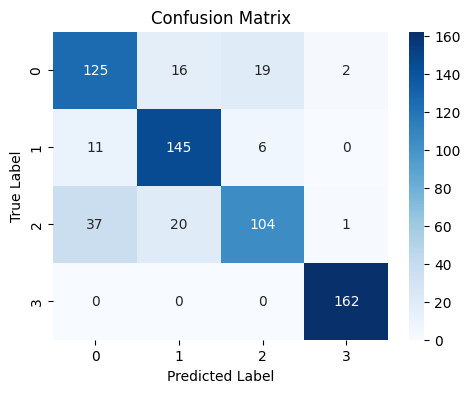

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
cm1 = cm(Y_test, final_pred)

# Plot the confusion matrix with a heatmap
plt.figure(figsize=(5.4, 4))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
####Exporting weights

!mkdir ./128_Log
np.save('/content/128_Log/128_Log_weights.npy', weights)
np.save('/content/128_Log/128_Log_stds.npy', stds)
np.save('/content/128_Log/128_Log_means.npy', means)

New = '/content/128_Log'
zip_filename = '/content/128_Log'
shutil.make_archive(zip_filename, 'zip', New)



# !mkdir ./64_Log
# np.save('/content/64_Log/64_Log_weights.npy', weights)
# np.save('/content/64_Log/64_Log_stds.npy', stds)
# np.save('/content/64_Log/64_Log_means.npy', means)

# New = '/content/64_Log'
# zip_filename = '/content/64_Log'
# shutil.make_archive(zip_filename, 'zip', New)

'/content/128_Log.zip'

In [ ]:
# !cp 128_Log.zip '/content/drive/MyDrive/CS613 Project'
# !cp 64_Log.zip '/content/drive/MyDrive/CS613 Project'